### What is this project about? (Plain English)

This project predicts how well a student will perform academically based on factors like:

Attendance

Internal marks

Study time

Previous scores

Demographic or academic background features

At the same time, it answers an important question:

What factors actually influence student performance the most?


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score
)

sns.set(style="whitegrid")


In [123]:
import requests
import zipfile
import io
import os

url = "https://archive.ics.uci.edu/static/public/320/student+performance.zip"

# Download zip
r = requests.get(url)
with zipfile.ZipFile(io.BytesIO(r.content)) as zip_ref:
    zip_ref.extractall()

# Check extracted files
os.listdir()


['.config',
 '.student.zip_old',
 'student.zip',
 'student.txt',
 'student-por.csv',
 'student-merge.R',
 'student-mat.csv',
 'sample_data']

In [51]:
with zipfile.ZipFile("student.zip", "r") as zip_ref:
    zip_ref.extractall()

os.listdir()

['.config',
 '.student.zip_old',
 'student.zip',
 'student.txt',
 'student-por.csv',
 'student-merge.R',
 'student-mat.csv',
 'sample_data']

In [52]:
df = pd.read_csv("student-mat.csv", sep=";")

In [53]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [54]:
df.shape


(395, 33)

In [55]:
df.columns


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [56]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [57]:
df["risk_level"] = pd.cut(
    df["G3"],
    bins=[-1, 9, 12, 20],
    labels=["High Risk", "Medium Risk", "Low Risk"]
)


In [58]:
df["risk_level"].value_counts()


,count
risk_level,
Medium Risk,134
Low Risk,131
High Risk,130


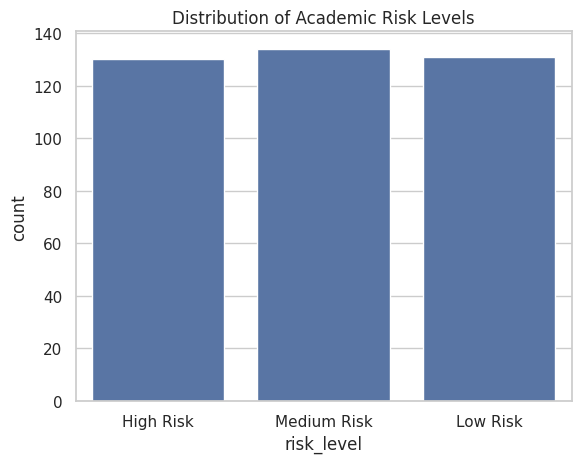

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="risk_level", data=df)
plt.title("Distribution of Academic Risk Levels")
plt.show()


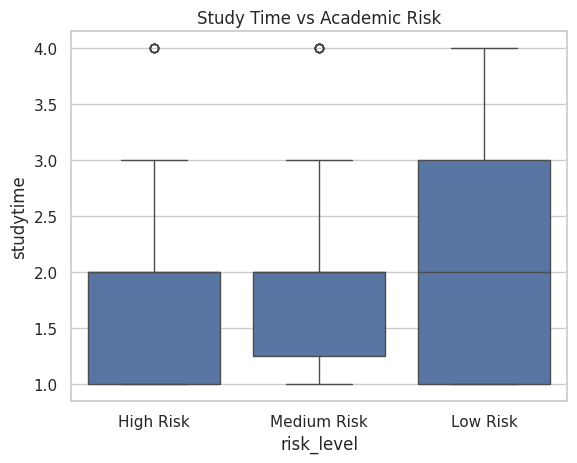

In [60]:
sns.boxplot(x="risk_level", y="studytime", data=df)
plt.title("Study Time vs Academic Risk")
plt.show()


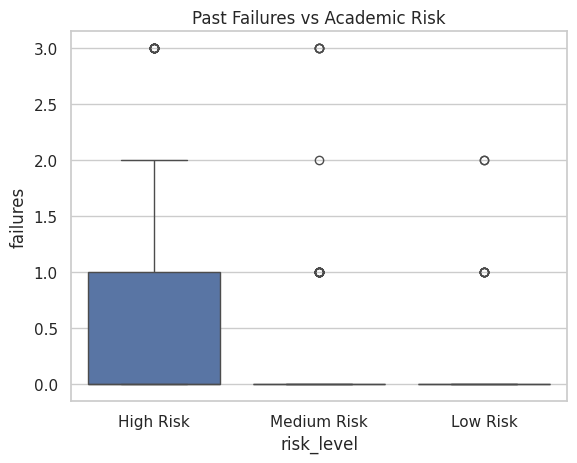

In [61]:
sns.boxplot(x="risk_level", y="failures", data=df)
plt.title("Past Failures vs Academic Risk")
plt.show()


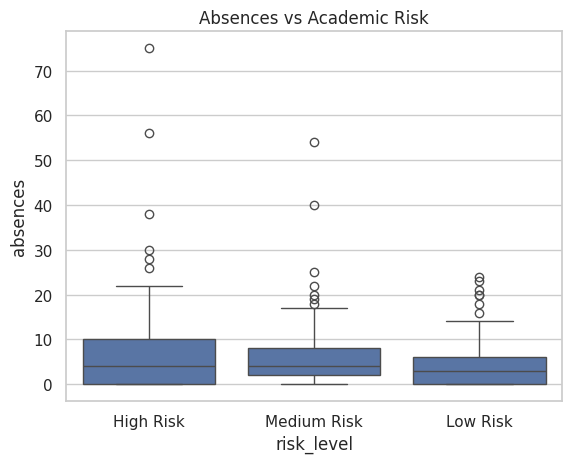

In [62]:
sns.boxplot(x="risk_level", y="absences", data=df)
plt.title("Absences vs Academic Risk")
plt.show()


## Analysis
- High-risk students tend to have lower study time and higher absences.
- Past academic failures show a strong association with increased academic risk.
.

In [63]:
df.isnull().sum()


,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


In [64]:
df.select_dtypes(include="object").nunique()


,0
school,2
sex,2
address,2
famsize,2
Pstatus,2
Mjob,5
Fjob,5
reason,4
guardian,3
schoolsup,2


In [66]:
df["high_risk"] = (df["risk_level"] == "High Risk").astype(int)


In [67]:
df["high_risk"].value_counts()


,count
high_risk,
0,265
1,130


In [68]:
df["avg_internal"] = (df["G1"] + df["G2"]) / 2
df["attendance_risk"] = (df["absences"] > 10).astype(int)
df["low_study_time"] = (df["studytime"] <= 2).astype(int)


In [69]:
df[["avg_internal", "attendance_risk", "low_study_time"]].head()


,avg_internal,attendance_risk,low_study_time
0,5.5,0,1
1,5.0,0,1
2,7.5,0,1
3,14.5,0,0
4,8.0,0,1


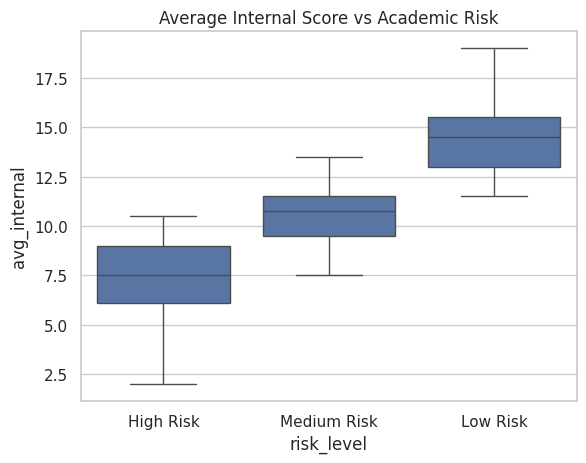

In [70]:
sns.boxplot(x="risk_level", y="avg_internal", data=df)
plt.title("Average Internal Score vs Academic Risk")
plt.show()


In [71]:
y = df["high_risk"]


In [72]:
X = df.drop(columns=["G3", "risk_level", "high_risk"])
